In [1]:
import os
import sys
sys.path.append("../../../..")
from nebula.evaluation import read_cv_data_splits, read_cv_metrics_folder
from nebula.evaluation.roc import get_model_rocs, allign_metrics
from nebula.misc.plots import plot_roc_curves, plot_cv_metrics_dict
from nebula.models.attention import TransformerEncoderChunks
from nebula.misc import get_path
SCRIPT_PATH = get_path(type="notebook")
REPO_ROOT = os.path.join(SCRIPT_PATH, *[".."]*4)
import numpy as np
from collections import defaultdict
from pandas import DataFrame, concat
FPRS = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
RUN_TYPES = ["adamw", "adam", "sgd"]

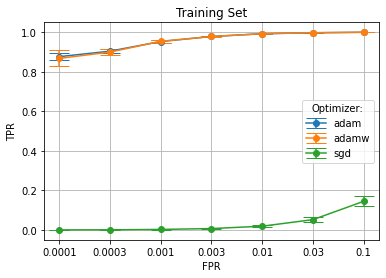

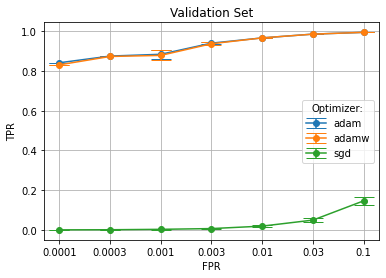

In [2]:
folder = "."
training_files = [x for x in os.listdir(folder) if x.endswith("training.json")]
validation_files = [x for x in os.listdir(folder) if x.endswith("validation.json")]

def training_filter(file):
    return file.endswith("training.json")
def validation_filter(file):
    return file.endswith("validation.json")
def key_extractor(file):
    return file.split("_")[1]

metrics_train = read_cv_metrics_folder('.', key_extractor, training_filter)
metrics_val = read_cv_metrics_folder('.', key_extractor, validation_filter)

TITLE = "Optimizer:"
newkeys = [x for x in metrics_train.keys()]
ax = plot_cv_metrics_dict(metrics_train, "tpr", legendTitle=TITLE, legendValues=newkeys)
ax.set_title("Training Set")

ax = plot_cv_metrics_dict(metrics_val, "tpr", legendTitle=TITLE, legendValues=newkeys)
_ = ax.set_title("Validation Set")

In [4]:
model_config = {
    "vocab_size": 50002,
    "maxlen": 512,
    "chunk_size": 64,
    "dModel": 64,
    "nHeads": 8,
    "dHidden": 256,
    "nLayers": 2,
    "numClasses": 1,
    "hiddenNeurons": [
        64
    ],
    "layerNorm": False,
    "dropout": 0.3,
    "mean_over_sequence": False
}

folder = os.path.join(SCRIPT_PATH, "..", "norm_first_limit_None_1677340681")
data_splits = read_cv_data_splits(folder)

roc_metrics_val = get_model_rocs(
    run_types=RUN_TYPES,
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
)

base_fpr_val, tprs_mean_val, tprs_std_val = allign_metrics(roc_metrics_val)

Model files:
	adamw: ['.\\training_files\\1677335344-model.torch', '.\\training_files\\1677335757-model.torch', '.\\training_files\\1677336156-model.torch']
	adam: ['.\\training_files\\1677336562-model.torch', '.\\training_files\\1677336955-model.torch', '.\\training_files\\1677337362-model.torch']
	sgd: ['.\\training_files\\1677577872-model.torch', '.\\training_files\\1677578335-model.torch', '.\\training_files\\1677578792-model.torch']

Evaluating adamw_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:24<00:00, 16.18it/s]


Evaluating adamw_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:21<00:00, 18.74it/s]


Evaluating adamw_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:22<00:00, 17.79it/s]


Evaluating adam_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:22<00:00, 17.86it/s]


Evaluating adam_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:21<00:00, 18.06it/s]


Evaluating adam_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:21<00:00, 18.18it/s]


Evaluating sgd_split_0 | Size: 5397377...


100%|██████████| 397/397 [00:20<00:00, 19.28it/s]


Evaluating sgd_split_1 | Size: 5397377...


100%|██████████| 397/397 [00:10<00:00, 39.60it/s]


Evaluating sgd_split_2 | Size: 5397377...


100%|██████████| 397/397 [00:10<00:00, 38.45it/s]


,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
adamw,0.612708,0.773956,0.880594,0.936977,0.968437,0.986220,0.995005,0.998912
adam,0.570154,0.698057,0.879667,0.937715,0.966648,0.985850,0.994986,0.999048
sgd,0.000019,0.000991,0.003537,0.007463,0.020270,0.051071,0.143929,0.395705


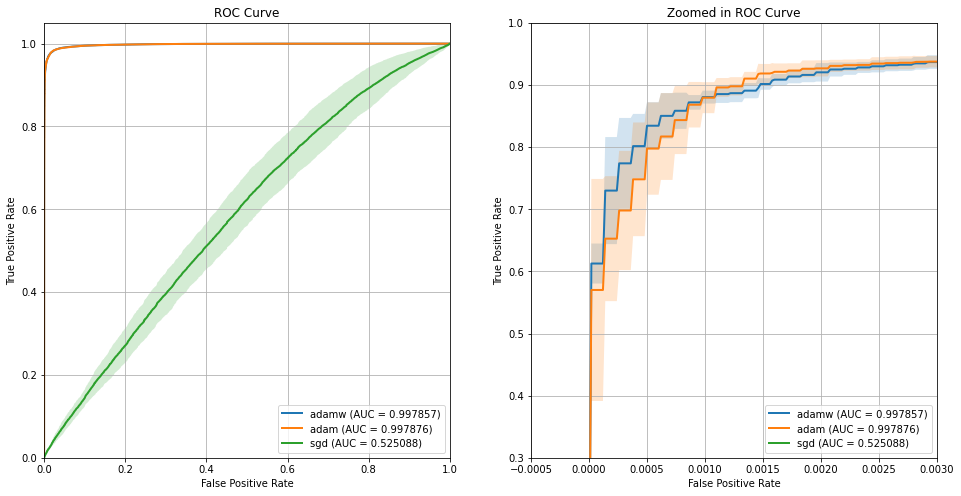

In [5]:
def report_metrics(base_fpr, tprs_mean, tprs_std, metrics, xlim=[-0.0005, 0.3], ylim=[0.6, 1]):
    tprsdf = DataFrame()
    for i, model_type in enumerate(tprs_mean.keys()):
        if i == 0:
            axs = None
        axs = plot_roc_curves(
            base_fpr, 
            tprs_mean[model_type], 
            tpr_std=tprs_std[model_type],
            model_name=f"{model_type}",
            axs=axs,
            roc_auc=metrics[model_type][0][2],
            xlim=xlim,
            ylim=ylim
        )
        tprs = defaultdict(list)
        for fpr in FPRS:
            tpr = tprs_mean[model_type][np.argmin(np.abs(base_fpr - fpr))]
            tprs[fpr].append(tpr)
        tprsdf = concat([tprsdf, DataFrame(tprs, index=[model_type])])
    [ax.grid() for ax in axs]
    _ = [ax.legend(loc='lower right') for ax in axs]
    return tprsdf

report_metrics(base_fpr_val, tprs_mean_val, tprs_std_val, roc_metrics_val, xlim=[-0.0005, 0.003], ylim=[0.3, 1.0])

## Test set ROCs

In [6]:
xtestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_vocab_size_50000_maxlen_512_x.npy")
X_test = np.load(xtestpath)
ytestpath = os.path.join(REPO_ROOT, r"data\data_filtered\speakeasy_testset_BPE_50k\speakeasy_y.npy")
y_test = np.load(ytestpath)

splits = 3
data_splits = [{"X_test": X_test, "y_test": y_test}]*splits

metrics = get_model_rocs(
    run_types=RUN_TYPES,
    model_class=TransformerEncoderChunks,
    model_config=model_config,
    data_splits=data_splits,
)

base_fpr, tprs_mean, tprs_std = allign_metrics(metrics)

Model files:
	adamw: ['.\\training_files\\1677335344-model.torch', '.\\training_files\\1677335757-model.torch', '.\\training_files\\1677336156-model.torch']
	adam: ['.\\training_files\\1677336562-model.torch', '.\\training_files\\1677336955-model.torch', '.\\training_files\\1677337362-model.torch']
	sgd: ['.\\training_files\\1677577872-model.torch', '.\\training_files\\1677578335-model.torch', '.\\training_files\\1677578792-model.torch']

Evaluating adamw_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:07<00:00, 38.63it/s]


Evaluating adamw_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:07<00:00, 38.74it/s]


Evaluating adamw_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:06<00:00, 41.77it/s]


Evaluating adam_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:06<00:00, 40.64it/s]


Evaluating adam_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:06<00:00, 40.38it/s]


Evaluating adam_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:08<00:00, 30.84it/s]


Evaluating sgd_split_0 | Size: 5397377...


100%|██████████| 272/272 [00:07<00:00, 35.67it/s]


Evaluating sgd_split_1 | Size: 5397377...


100%|██████████| 272/272 [00:07<00:00, 38.48it/s]


Evaluating sgd_split_2 | Size: 5397377...


100%|██████████| 272/272 [00:06<00:00, 38.87it/s]


,0.0001,0.0003,0.0010,0.0030,0.0100,0.0300,0.1000,0.3000
adamw,0.162679,0.393101,0.547520,0.650537,0.744727,0.833280,0.893580,0.960970
adam,0.212273,0.380446,0.564146,0.656812,0.754405,0.839519,0.895565,0.958914
sgd,0.000319,0.000957,0.002446,0.004573,0.016094,0.042043,0.129179,0.365805


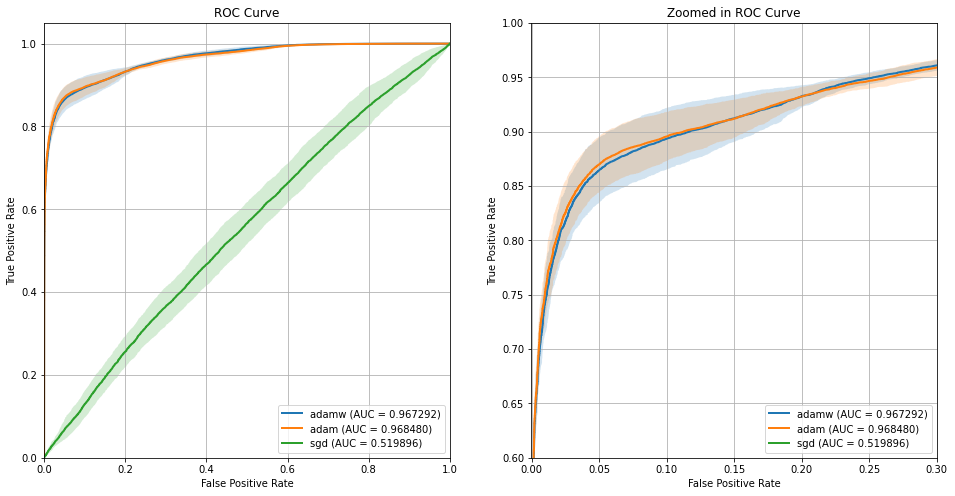

In [7]:
report_metrics(base_fpr, tprs_mean, tprs_std, metrics)